In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
from IPython.display import display, Markdown, Latex
import sys
sys.path.append("/n/home12/khou/holystore/")
import paper_utils
from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr, kendalltau
import seaborn as sns
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42


plot_trait_list =[
    "UKB_460K.body_HEIGHTz",
    "PASS_MDD_Howard2019",
    "PASS_Schizophrenia_Ruderfer2018",
    "UKB_460K.cov_EDU_COLLEGE",
] + ["spatial_ventral", "spatial_dorsal", "spatial_proximal", "spatial_distal"]


In [2]:
DATA_PATH = "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data"
URL_SUPP_TABLE = "https://www.dropbox.com/s/qojbzu5zln33j7f/supp_tables.xlsx?dl=1"

df_trait_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=0,
)

dict_trait_code = {
    row["Trait_Identifier"]: row["Code"] for _, row in df_trait_info.iterrows()
}

dict_trait_code["spatial_ventral"] = "Ventral"
dict_trait_code["spatial_dorsal"] = "Dorsal"
dict_trait_code["spatial_proximal"] = "Proximal"
dict_trait_code["spatial_distal"] = "Distal"

In [3]:
N_CTRL=1000

# Ayhan et al. 2021

In [4]:
# load adata and load score
processed_dir = "00_prepare_dataset/processed"

dict_adata = dict()
for dataset in ["ayhan_2021", "habib_2016"]:
    if dataset == "ayhan_2021":
        adata = sc.read_h5ad(join(processed_dir, "ayhan_2021.raw.h5ad"))
        adata = adata[adata.obs["Cluster"].isin(["Pyr1", "Pyr2"])]
    elif dataset == "habib_2016": 
        adata = sc.read_h5ad(join(processed_dir, "habib_2016.processed.h5ad"))
        adata = adata[adata.obs.CLUSTER == "CA1"]
    for trait in plot_trait_list:
        temp_df = pd.read_csv(join("01_score_cell/score_file", dataset, f"{trait}.score.gz"), sep="\t", index_col=0)
        if trait.startswith("spatial_"):
            adata.obs[trait] = temp_df["norm_score"].reindex(adata.obs.index)
        else:
            adata.obs[trait] = temp_df["zscore"].reindex(adata.obs.index)
    dict_adata[dataset] = adata

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


spatial_dorsal: posterior - anterior p-value: 0.996
spatial_ventral: posterior - anterior p-value: 0.008


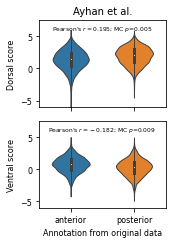

In [5]:
dataset = "ayhan_2021"
adata = dict_adata[dataset]

stats_dict = {}
pval_dict = {}
# obtain statistical significance via MC p-values
spatial_trait_list = ["spatial_dorsal", "spatial_ventral"]
for trait in spatial_trait_list:
    df_tmp = pd.read_csv(join("01_score_cell/score_file", dataset, f"{trait}.full_score.gz"), sep="\t", index_col=0)
    df_tmp = adata.obs[["group"]].merge(df_tmp, left_index=True, right_index=True)
    corr = pearsonr(df_tmp["group"].cat.codes, df_tmp["norm_score"])[0]

    ctrl_corr = [pearsonr(df_tmp["group"].cat.codes, df_tmp[f"ctrl_norm_score_{ctrl_i}"].values)[0] for ctrl_i in range(N_CTRL)]

    print(f"{trait}: posterior - anterior p-value: {np.mean(corr > ctrl_corr)}")
    pval_dict[trait] = np.sum(corr > ctrl_corr)
    pval_dict[trait] = min(N_CTRL - pval_dict[trait] + 1, pval_dict[trait] + 1) / (N_CTRL + 1)
    stats_dict[trait] = corr
    

spatial_trait_list = ["spatial_dorsal", "spatial_ventral"]
for trait in spatial_trait_list:
    temp_df = pd.read_csv(join("01_score_cell/score_file", dataset, f"{trait}.score.gz"), sep="\t", index_col=0)
    adata.obs[trait] = temp_df["zscore"].reindex(adata.obs.index)

df = adata.obs[["group", "spatial_dorsal", "spatial_ventral"]]
df = df[(df["spatial_dorsal"] > -10) & (df["spatial_ventral"] > -10)]

fig, ax = plt.subplots(figsize=(2.5, 3.5), nrows=2, sharex=True)
plots = []
for i, col in enumerate(["spatial_dorsal", "spatial_ventral"]):
    g = sns.violinplot(data=df, x="group", y=col, linewidth=1, notch=True, width=0.6, ax=ax[i])
    plots.append(g)
    ax[i].set_ylabel(dict_trait_code[col] + ' score', fontsize=8)
    ax[i].tick_params(axis='both', which='major', labelsize=8)
    ax[i].tick_params(axis='both', which='minor', labelsize=6)
    ax[i].set_ylim(-6, 7.5)
    ax[i].text(0.5, 6, f"Pearson's $r={stats_dict[col]:.3g}$; MC $p$={pval_dict[col]:.2g}", ha='center', fontsize=6)
plots[0].set(xlabel=None)
ax[0].set_title("Ayhan et al.", fontsize=10)

plt.xlabel("Annotation from original data", fontsize=8)
plt.tight_layout()
plt.show()


# Habib et al. 2016

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


spatial_dorsal: p-value: 0.0


/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


spatial_ventral: p-value: 1.0


/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


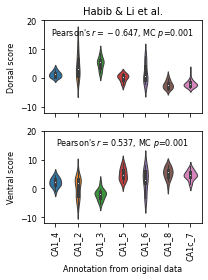

In [6]:
dataset = "habib_2016"
orders = ['CA1_4', 'CA1_2', 'CA1_3', 'CA1_5', 'CA1_6', 'CA1_8', 'CA1c_7']

adata = dict_adata[dataset]

stats_dict = dict()
pval_dict = dict()
# obtain statistical significance via MC p-values
spatial_trait_list = ["spatial_dorsal", "spatial_ventral"]
for trait in spatial_trait_list:
    df_tmp = pd.read_csv(join("01_score_cell/score_file", dataset, f"{trait}.full_score.gz"), sep="\t", index_col=0)
    df_tmp = adata.obs[["SUB-CLUSTER"]].merge(df_tmp, left_index=True, right_index=True)
    df_tmp = df_tmp[df_tmp["SUB-CLUSTER"] != 'CA1_1']
    df_tmp["SUB-CLUSTER"].cat.remove_unused_categories(inplace=True)
    df_tmp["SUB-CLUSTER"].cat.reorder_categories(orders, inplace=True)
    df_tmp["SUB-CLUSTER-CODE"] = df_tmp["SUB-CLUSTER"].cat.codes
    cor = pearsonr(df_tmp["SUB-CLUSTER-CODE"], df_tmp["norm_score"].values)[0]
    ctrl_cor = [pearsonr(df_tmp["SUB-CLUSTER-CODE"], df_tmp[f"ctrl_norm_score_{ctrl_i}"].values)[0] for ctrl_i in range(N_CTRL)]
    print(f"{trait}: p-value: {np.mean(cor > ctrl_cor)}")
    pval_dict[trait] = np.sum(cor > ctrl_cor)
    pval_dict[trait] = min(N_CTRL - pval_dict[trait] + 1, pval_dict[trait] + 1) / (N_CTRL + 1)
    stats_dict[trait] = cor
    
df = adata.obs[["SUB-CLUSTER", "spatial_dorsal", "spatial_ventral"]]
df = df[(df["spatial_dorsal"] > -10) & (df["spatial_ventral"] > -10)]
df = df[df["SUB-CLUSTER"] != 'CA1_1']
df["SUB-CLUSTER"].cat.remove_unused_categories(inplace=True)

# 'CA1_1', 
fig, ax = plt.subplots(figsize=(3, 4), nrows=2, sharex=True)
plots = []
for i, col in enumerate(["spatial_dorsal", "spatial_ventral"]):
    g = sns.violinplot(data=df, x="SUB-CLUSTER", y=col, linewidth=1, order=orders, notch=True, width=0.6, ax=ax[i])
    plots.append(g)
    ax[i].set_ylabel(dict_trait_code[col] + ' score', fontsize=8)
    ax[i].tick_params(axis='both', which='major', labelsize=8)
    ax[i].tick_params(axis='both', which='minor', labelsize=6)
    
#     ax[i].set_yticklabels(ax[i].get_yticklabels(), fontsize=10)
    ax[i].set_ylim(-12, 20)
    ax[i].text(3, 15, f"Pearson's $r={stats_dict[col]:.3g}$, MC $p$={pval_dict[col]:.1g}", ha='center', fontsize=8)
    
plots[0].set(xlabel=None)
ax[0].set_title("Habib & Li et al.", fontsize=10)

plt.xlabel("Annotation from original data", fontsize=8)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()